# 2020.06.07_pca_baselines
-----
Chain of baselines with 
*   pca features


### Version Info
* madmax: `13fea37`
* research: `3d47f5a`

---
## History

#### 2020.06.04_recap
Recap of all models to date
*   basic online model with rolling window (no technical features)
*  disjoint returns
*   online learning with Q and P-omega weights
* boosting / sequential residualization
*   technical features
*   pca features


#### 2020.06.03_multi_return_online_model

* updateing online rnn to support multiple disjoint return


#### 2020.06.01_online_pca
* Reimplemeting statfacs using online pca


#### `2020.05.28_baselines.ipynb`
-----
* Baselines for the technical features data 
* testing gradeitn descent vs mbprox
* testing fast vs slow hl_2 in onlineRnn

#### `2020.05.27 statfacs grid`
* Statfacs initialized with the loadings from the previous minibatch
* Building an online model using statfacs as both features and residualization target
* Comprehensive grid of statfacs


##### `etf_technical_2020.05.27 (more statfacs)`
* Statfacs initialized with the loadings from the previous minibatch
* Building an online model using statfacs as both features and residualization target


##### `etf_technical_2020.05.19 (stat factors).ipynb`
* Computed statistical factors using
    + random initialization  in minibatches
    + iteratively added new statfacs - maintaining orthogonality to previous statfacs
    + different kappas and window lenghts
* Established baselines for the model withotu statfacs
* Ran some basic regressions with statfacs (not residualization)



##### `etf_technical_2020.05.17 (features profiling).ipynb`. 
* adding ta-lib like features for 500 ETFs. Feature profiled, online learning model

##### `etf_technical_2020.05.13`
* I had gotten omega weighting done (seems to add a little bit but not much)


In [27]:
xs = [tr.randn(100, 10, device='cuda') for _ in range(10)]

RuntimeError: CUDA error: out of memory

In [24]:
%%timeit




151 ns ± 0.566 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [25]:
%%timeit
a = [1,2,3]
a.append( 3 )
a = a[-2:]

154 ns ± 6.75 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [7]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler
%load_ext line_profiler

from pylab import *
from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()
plt.style.use('seaborn-whitegrid')

###################################################################
# Interactive configuration
# When running a config grid this will throw a FrozenException
# and the grid Config will be used
###################################################################
try:
    mx.Config.name = 'etf_technical/2020.06.07_pca_baselines/'
    mx.Config.mode = 'interactive'
    mx.Config.hps = mx.HPSet(
        start = '20070101',
        end='20200501',
        INTS_PER_DAY = 13,        
    )
    mx.Config.code = '2020.06.04_recap.ipynb'
    disp('Running interactive configuration ', h=2)
except mx.Config.FrozenException:
    if mx.Config.mode != 'grid':
        raise RuntimeError('An unexpected configruation encountered')
    disp('Running a grid configuration ', h=2)

device = 'cuda'
dtype = tr.float32
Config.start()
hps = mx.Config.hps

# to run run a grid of hyperparameters ...
####################################
# # hyperparameters
# mx.Config.hps = fr.HPSet(
# )
# mx.Config.code = ''
# # configs = []
# # for obs_weight in ['no_weight', 'dollar_weight', 'log_weight']:
# #     cfg = fr.Config.clone()
# #     cf
# #     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
# #     cfg.freeze()
# #     display_html( cfg )
# #     configs.append( cfg )
# # notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - weight_grid_results.ipynb', n_jobs=None )

Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


AttributeError: type object 'mx' has no attribute 'Config'

## interactive global hyperparameters

In [20]:
# global  configruation
#######
if mx.Config.mode == 'grid':
    raise mx.Config.FrozenException( 'running grid configruation - skipping')


hps.universe = mx.HPSet(
    start = '20100101',
    end='20200401',
    min_count=2000,
    min_dollar_vol=1e5
)


hps.feature_set = mx.HPSet(
    unadj_prices=[
        'open_unadj_30min', 'high_unadj_30min', 'low_unadj_30min', 'close_unadj_30min', 'mid_unadj_30min',
        'log_open_unadj_30min', 'log_close_unadj_30min',
    ],
    adj_prices=[
        'open_adj_30min', 'high_adj_30min', 'low_adj_30min', 'close_adj_30min',
        'mid_adj_30min', 'mid_adj_0D.12h.vwap', 'mid_adj_2D.12h.vwap', 'mid_adj_5D.vwap',
        'open_adj_0D.12h', 'high_adj_0D.12h', 'low_adj_0D.12h',
        'open_adj_2D.12h', 'high_adj_2D.12h', 'low_adj_2D.12h',
        'open_adj_5D', 'high_adj_5D', 'low_adj_5D',
    ],
    rel_prices=[
        'rel_price_260', 'rel_price_780', 'rel_price_3276',
    ],
    volumes=[
        'volume_unadj_30min', 'dollar_volume_unadj_30min', 'avg_dollar_volume',
    ],
    log_volumes=[
        'log10_dollar_volume_30min', 'log10_dollar_volume_30min_resid',
    ],
    rel_volume=[
        'rel_dollar_volume_260', 'rel_dollar_volume_780',
        'rel_dollar_volume_3276',
    ],
    calendar=[
        'timeofday', 'cos1_timeofday', 'cos2_timeofday', 'cos4_timeofday',
        'dayofweek', 'cos1_dayofweek', 'cos2_dayofweek',
        'weekofmonth', 'cos1_weekofmonth', 'cos2_weekofmonth',
        'monthofquarter', 'cos1_monthofquarter', 'cos2_monthofquarter',
        'quarterofyear', 'cos1_quarterofyear', 'cos2_quarterofyear',
    ],
    lagging=[
        'lagrtn_adj_30min', 'lagrtn_adj_1hr', 'lagrtn_adj_1day',
        'lagrtn_adj_30min_resid',
    ],
    mkt=[
        'mkt_lagrtn_30min',
        'mkt_lagrtn_30min_260.rw_sd', 'mkt_lagrtn_30min_780.rw_sd', 'mkt_lagrtn_30min_3276.rw_sd',
    ],
    vol=[
        'lagrtn_adj_30min_260.rw_sd', 'lagrtn_adj_30min_780.rw_sd', 'lagrtn_adj_30min_3276.rw_sd',
        'lagrtn_adj_30min_resid_260.rw_sd', 'lagrtn_adj_30min_resid_780.rw_sd', 'lagrtn_adj_30min_resid_3276.rw_sd',
    ],
    zscores=[
        'lagrtn_adj_30min_260.rw_zscore', 'lagrtn_adj_30min_780.rw_zscore', 'lagrtn_adj_30min_3276.rw_zscore',
        'lagrtn_adj_30min_resid_260.rw_zscore', 'lagrtn_adj_30min_resid_780.rw_zscore',
        'lagrtn_adj_30min_resid_3276.rw_zscore',
    ],
    betas=[
        'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min_2340.ew_beta',
        'lagrtn_adj_30min_3276.ew_beta', 'lagrtn_adj_30min_6500.ew_beta',
    ],
    afacs=[ 'bw_afac_30min', 'fw_afac_30min' ],
    technical=[
        'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
        'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
        'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
        'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
        'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
    ],    
)

hps.leading_rtns = [
    'leadrtn_adj_30min', 'leadrtn_adj_1hr', 'leadrtn_adj_1day',
    'mkt_leadrtn_30min', 'mkt_leadrtn_1day',
    'leadrtn_adj_30min_disjoint.1', 'leadrtn_adj_30min_disjoint.2', 'leadrtn_adj_30min_disjoint.3',
]

hps.weights = ['valid_30min', 'weight', ]
    
baselines = OrderedDict()

<IPython.core.display.Javascript object>


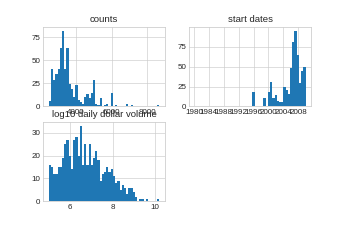

In [13]:
# identify the universe of ETFS
#############################################################
%nbagg
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )

etf_stats = etfd.compute_etf_stats()
etf_stats = etf_stats[etf_stats.vendor=='kibot']
orig_len = len( etf_stats )
# drop etfs without enough history
etf_stats = etf_stats[(etf_stats['start'] <= hps.universe.start ) 
                      & (etf_stats['end'] > hps.universe.end ) 
                      & (etf_stats['n'] >= hps.universe.min_count)
                      & (etf_stats['daily_dollar_volume_adj'] >= hps.universe.min_dollar_vol ) ]

disp( 'after filtering', len( etf_stats ), 'symbols out of original ' ,orig_len )

etf_stats = (etf_stats
             .merge( etfd.all_etfs, how='left', left_on='symbol', right_on='Symbol' )
             .drop( columns=['Symbol', 'ETP Name', 'Leveraged / Inverse' ])
             .rename( columns={'Asset Class':'asset_class', 'Description':'name'} )
             .fillna( 'Not Specified')             
             .set_index('symbol')
            )
disp( etf_stats.groupby('asset_class').name.count() )

ax = subplot( 2,2, 1 )
etf_stats.n.hist(ax=ax, bins=50)
ax.set_title( 'counts')

ax = subplot( 2,2, 2 )
etf_stats.start.hist(ax=ax, bins=50)
ax.set_title( 'start dates')

ax = subplot( 2,2, 3 )
etf_stats.daily_dollar_volume_adj.log10().hist(ax=ax, bins=50)
ax.set_title( 'log10 daily dollar volume')

# this is the universe we will work with. 
# HERO has a massive returns spike in 2015.11.09 - which throws off residualization quite a bit.
hps.universe.symbols = sorted( etf_stats.index.values )


In [4]:
# build up the data and features
#############################################
%inline
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )
from research.etf_technical import etf_technical_20200517 as etfrc; reload( etfrc )

# fetch the data as a dataarray
builder = etfd.BuildDataWithAfacs( symbols=hps.universe.symbols, mkt_only=True, start=hps.start ,).set( memoize=True )
builder.data = None
disp( 'builder BuildDataWithAfacs_7f79ef4bf  expected got', builder.hash() )
da = builder(  )
df = builder.output_meta

# hyperparams related to computing returns and residuals
hps.returns_hps = mx.HPSet(    
    price_windows=[ 24*1, 24*5, 24*10],
    beta_halflifes=[13 * 90, 13 * 180, 13 * 252, 13*500],
    dollar_volume_window=13*180,
    ema_halflifes=[20 * 13, 60 * 13, 252 * 13],
    resid_halflife=13,
    
)
# compute log-returns, log-dollar-volume, betas, residual returns and clean up the data
rtn_computer = etfrc.compute_returns_and_betas( 
    start=hps.start, end=None,     
    dollar_volume_window=hps.returns_hps.dollar_volume_window, 
    price_windows = hps.returns_hps.price_windows,
    beta_halflifes=hps.returns_hps.beta_halflifes, 
    resid_halflife=None,    
) 
rtn_computer.data = builder
disp( 'expected compute_returns_and_betas_9280a30dd got', rtn_computer.hash(), h=4, color='teal' )

# add relative price and relative volume features
rel_price_and_vols = etfrc.add_relative_price_and_volumes( emas=hps.returns_hps.ema_halflifes )
rel_price_and_vols.data = rtn_computer
disp( 'expected add_relative_price_and_volumes_a65da371a got', rel_price_and_vols.hash(), h=4, color='teal' )

# add volatility and calendar features
add_vols = etfrc.add_volatilities( emas=hps.returns_hps.ema_halflifes )
add_vols.data = rel_price_and_vols
disp( 'expected add_volatilities_77ca914f0 got', add_vols.hash(), h=4, color='teal' )

# add disjoint returns
disjoint_returns= etfrc.add_dijoint_returns( lags=(1, 2, 3) )
disjoint_returns.data = add_vols
disjoint_returns.features = 'leadrtn_adj_30min'
disp( 'expected add_dijoint_returns_ed1f196d1 got', disjoint_returns.hash(), h=4, color='teal' )
da = disjoint_returns(   )

# OnlineRunner_854f955c7 
### Online pca (no kappa), factors as features and as residualizaiton target (standalone )

# This one is going to be broken since I fucking deleted the baseline directory 


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 4.135812758931934e-08
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 4.1358131142033017e-08
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )
/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 1.3731533954342012e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 7.705569942118018e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 1.3339851534510672e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 1.623863141730908e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 7.76196955598607e-08
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 7.761970266528806e-08
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )
/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 4.408286002899331e-08
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 4.6625908112218895e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 1.0286962037753256e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


/home/fj/cloud/code/madmax/pytorch/modules/normalizations.py:122: UserWarning: norm of X is dangerously low 1.028696132721052e-07
  warnings.warn( f'norm of X is dangerously low {X_norm.min()}' )


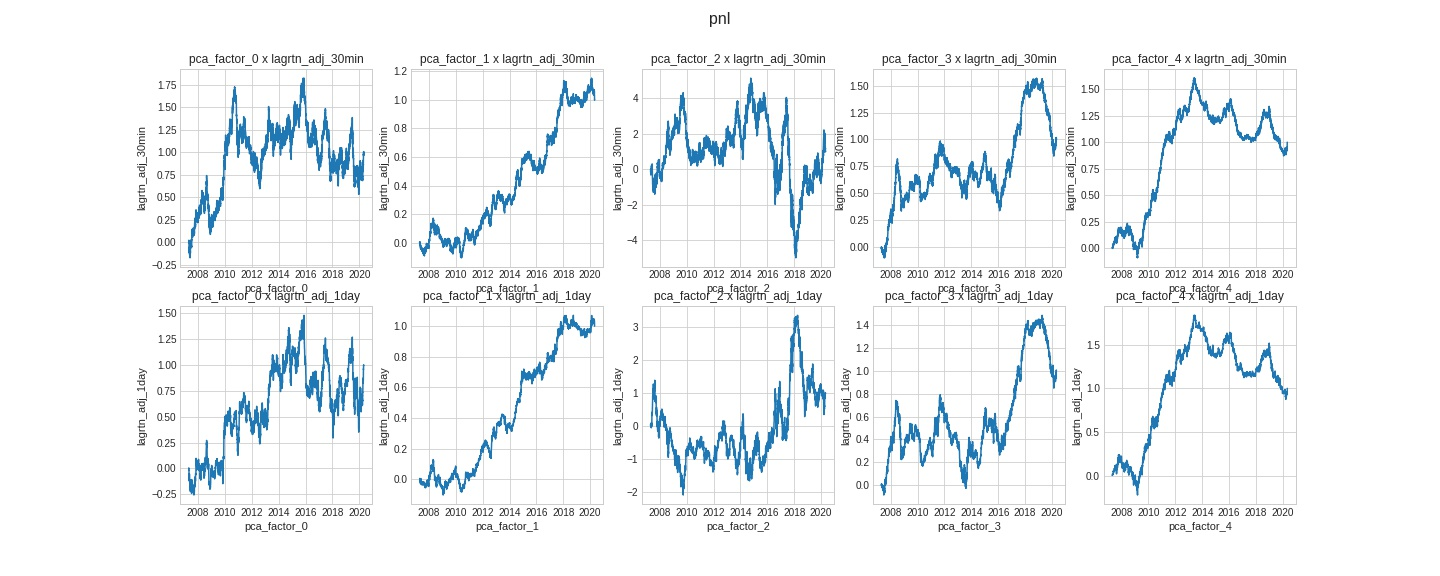

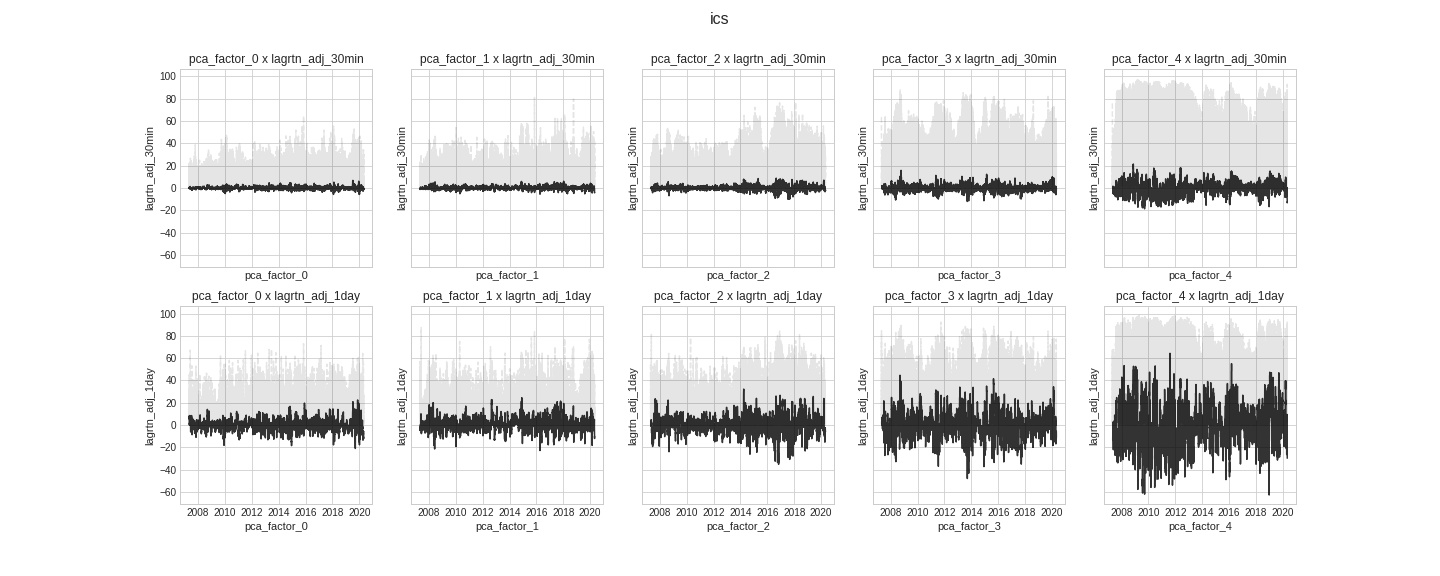

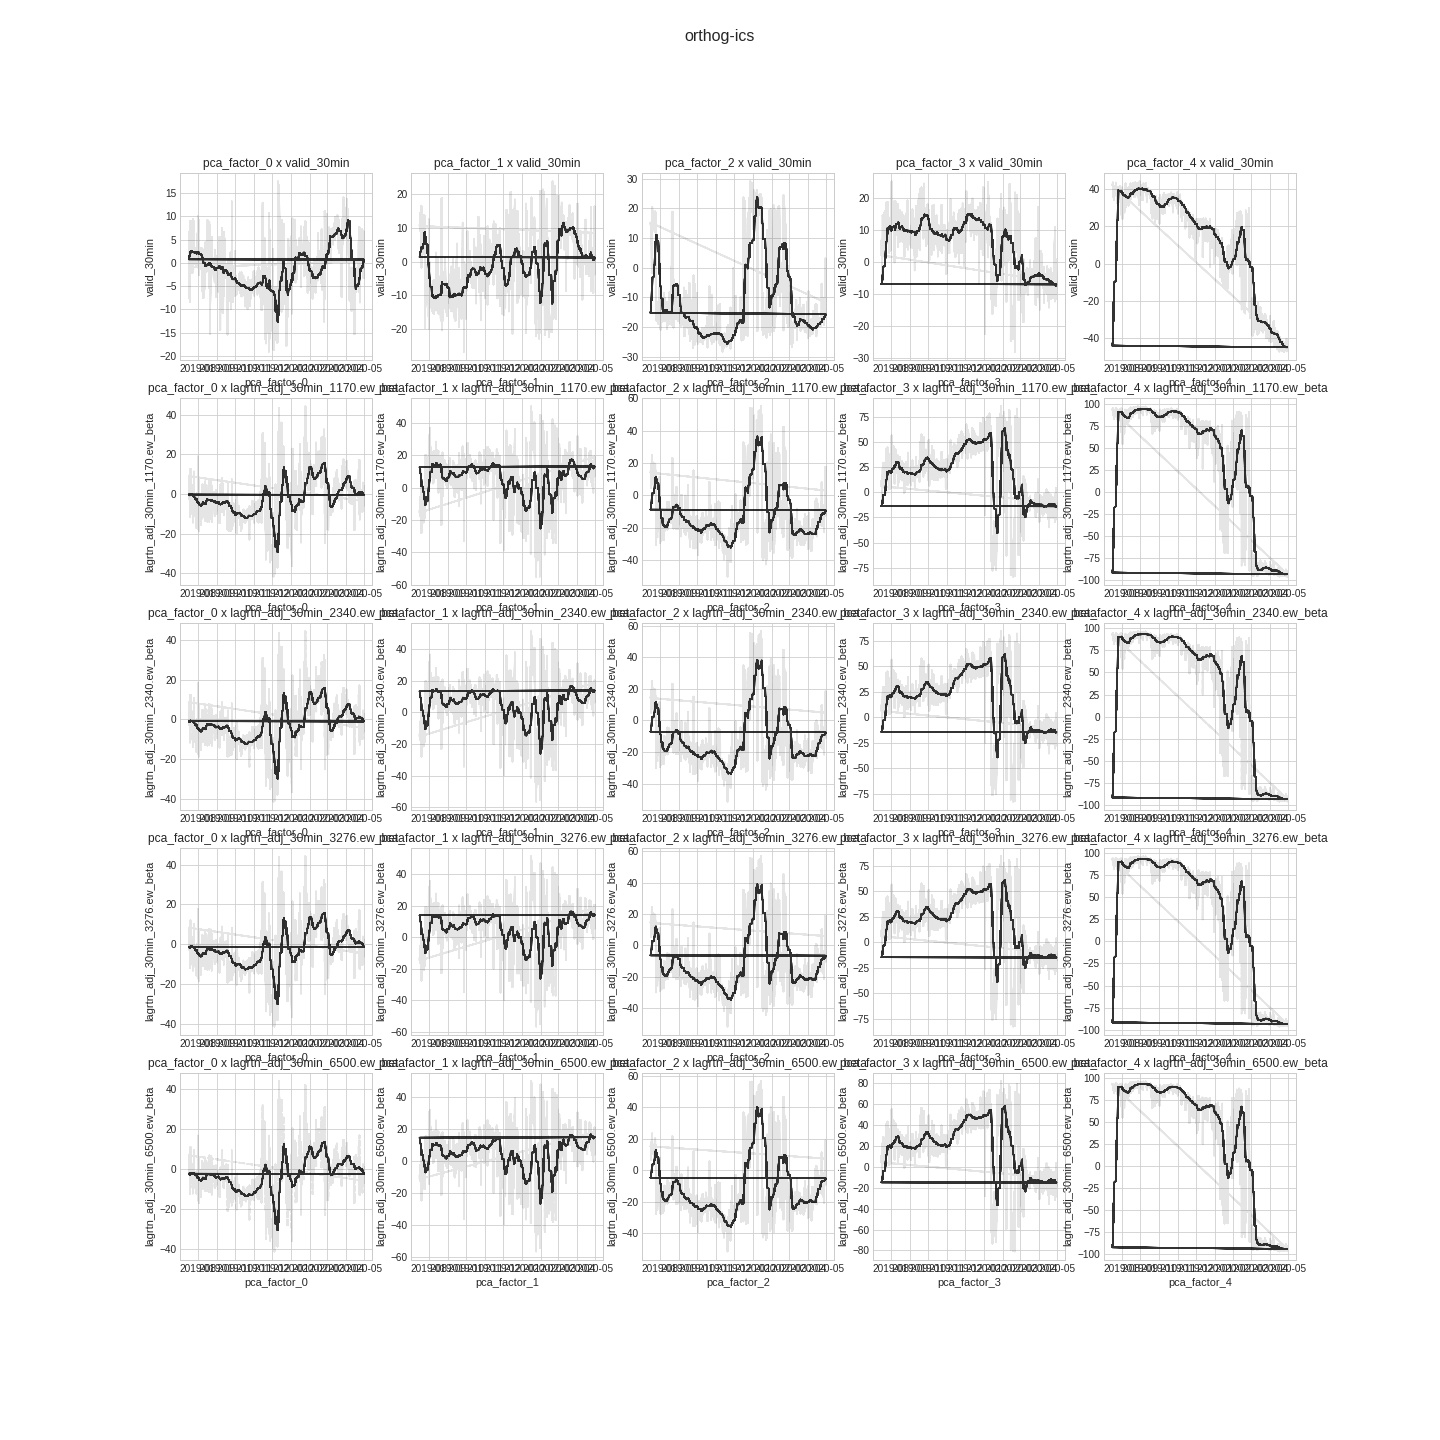

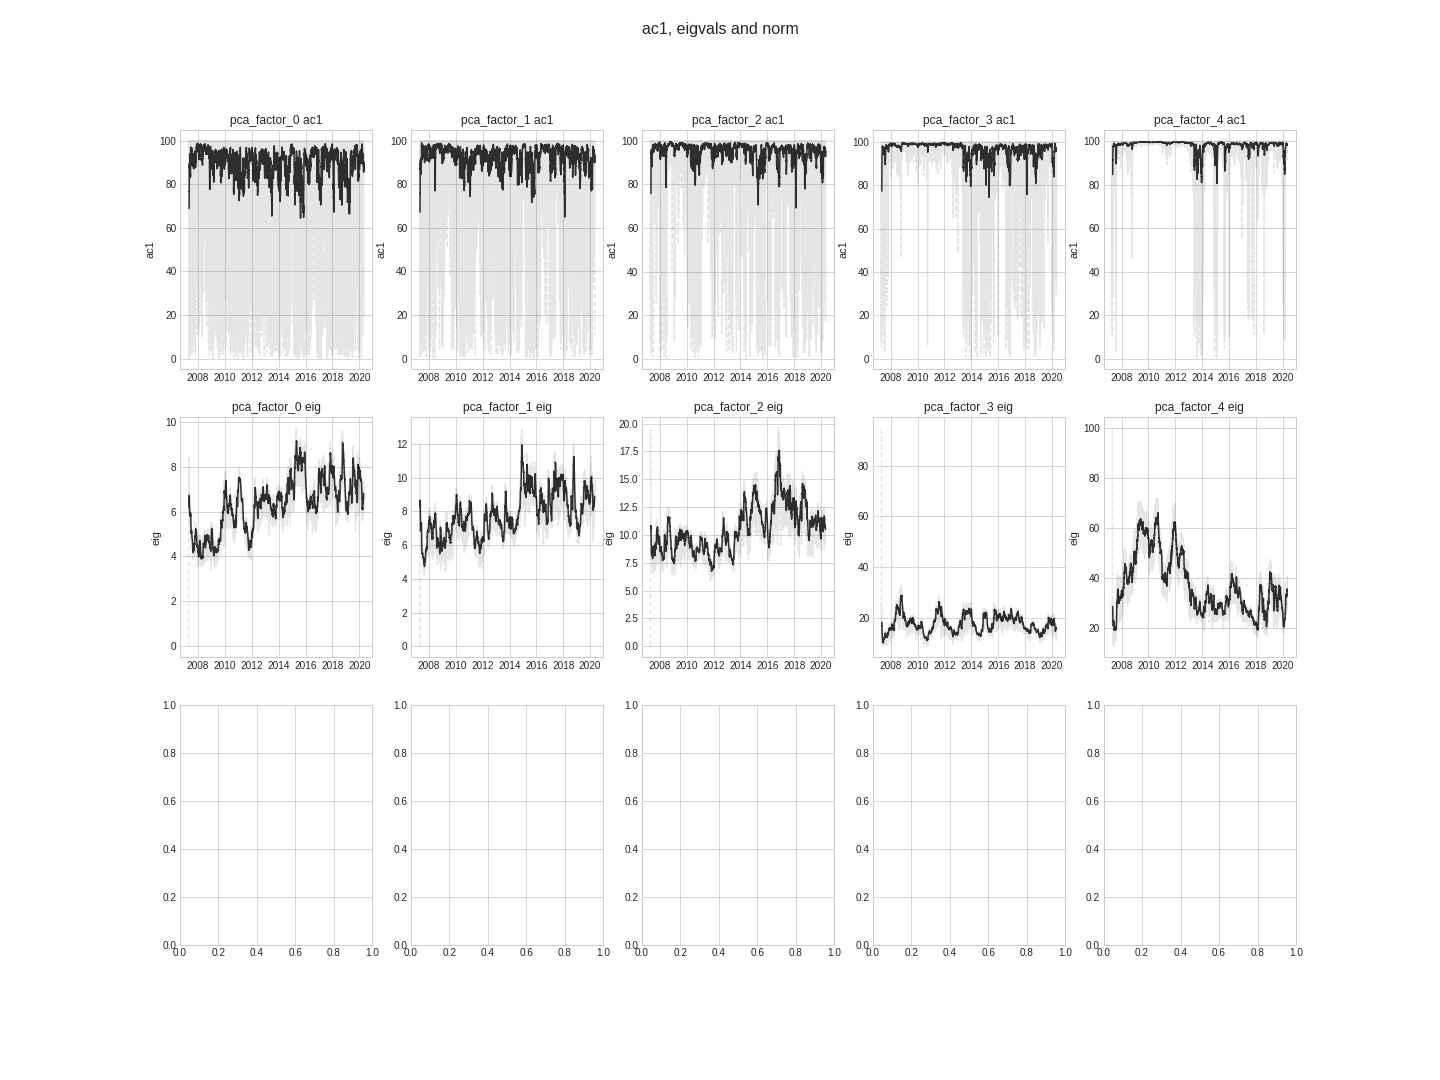

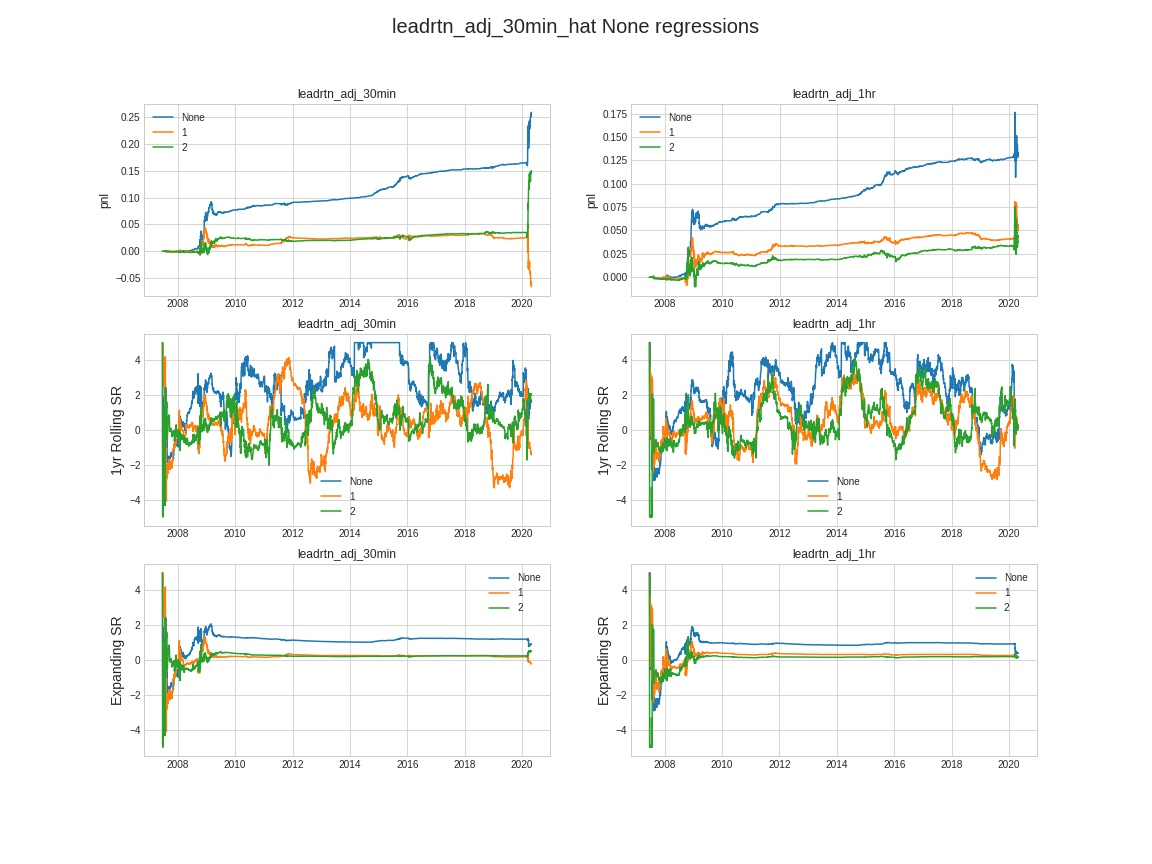

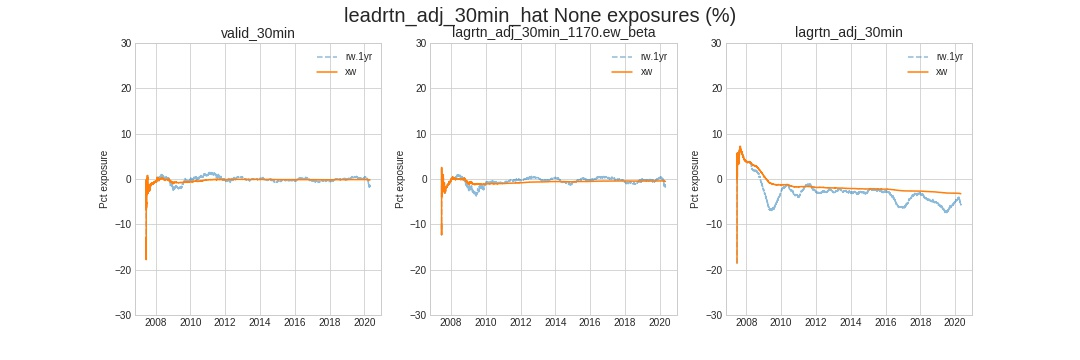

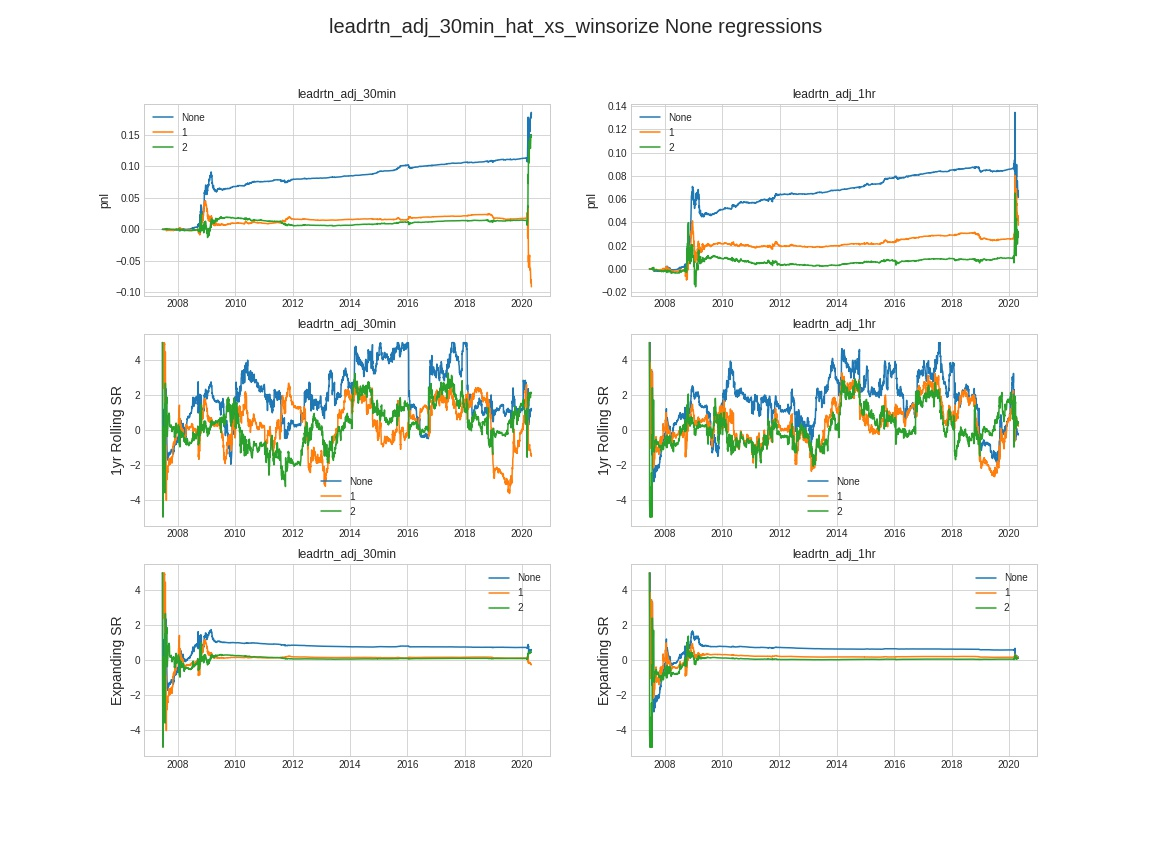

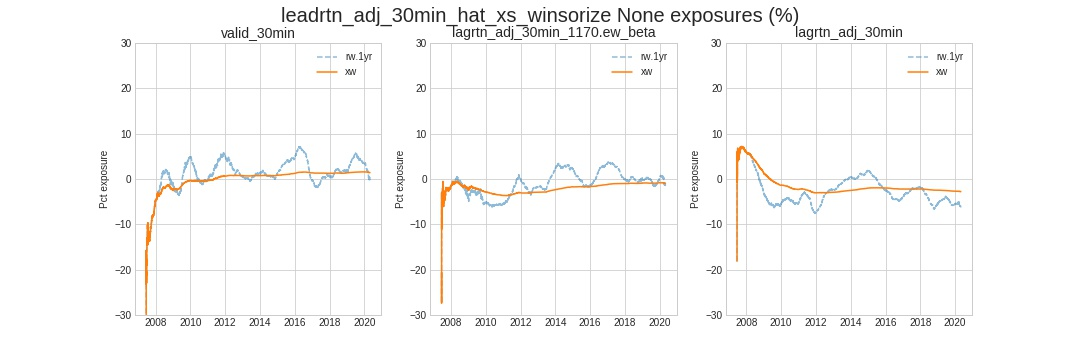

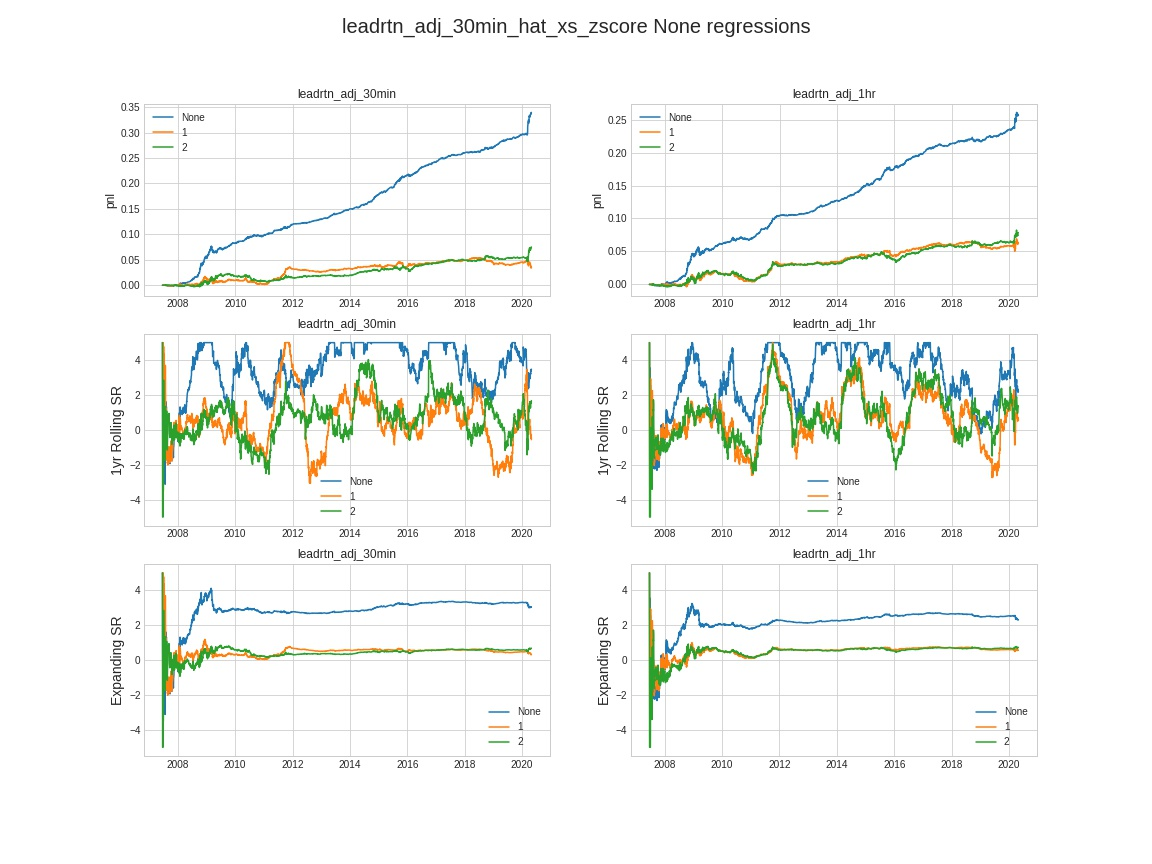

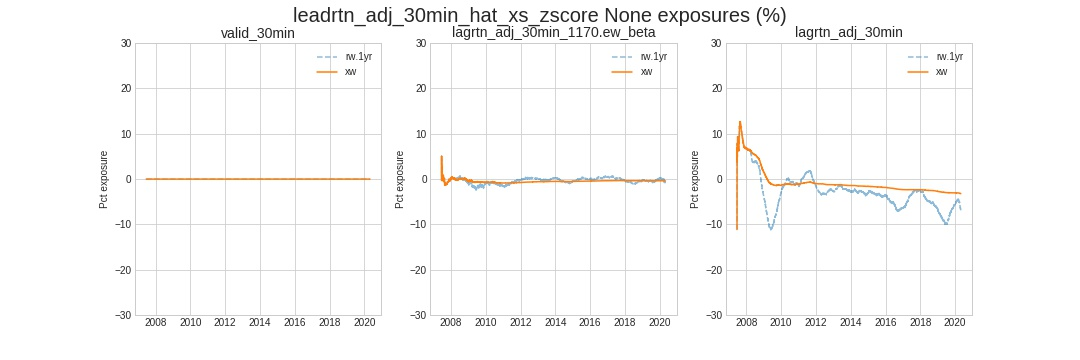

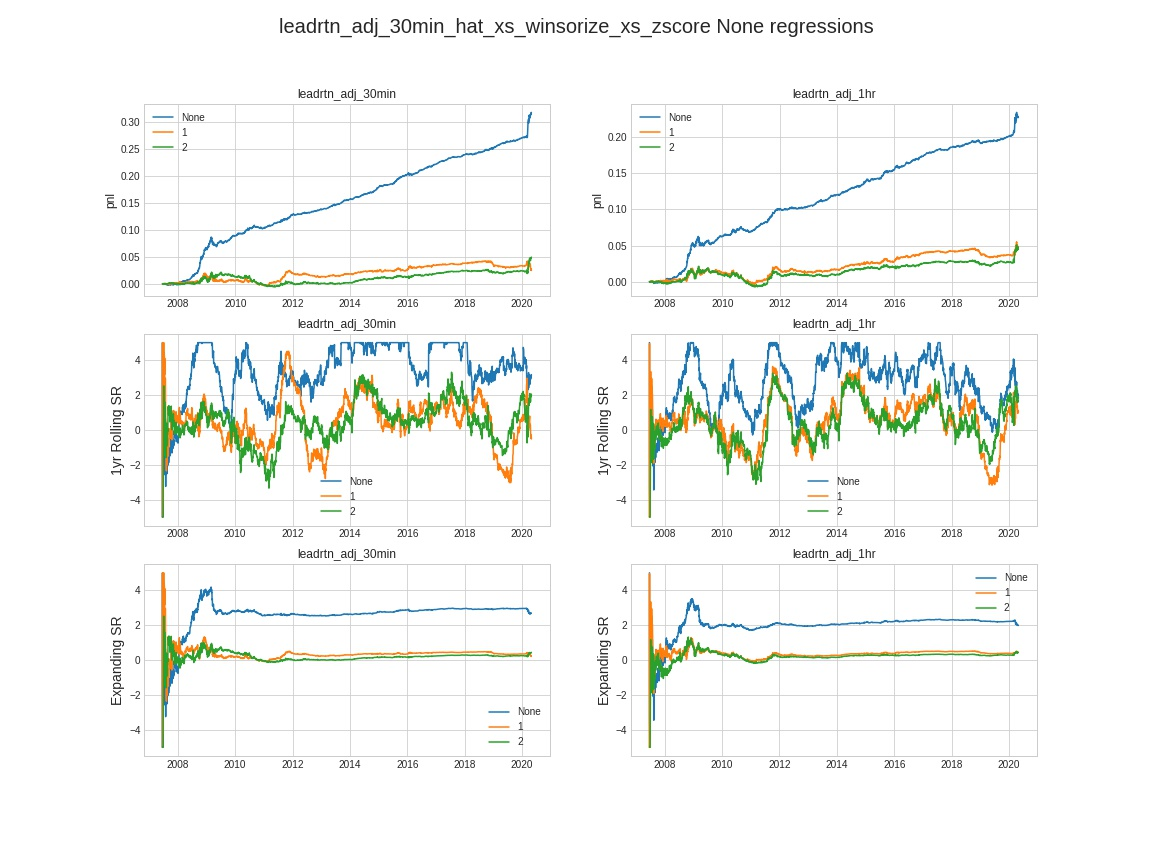

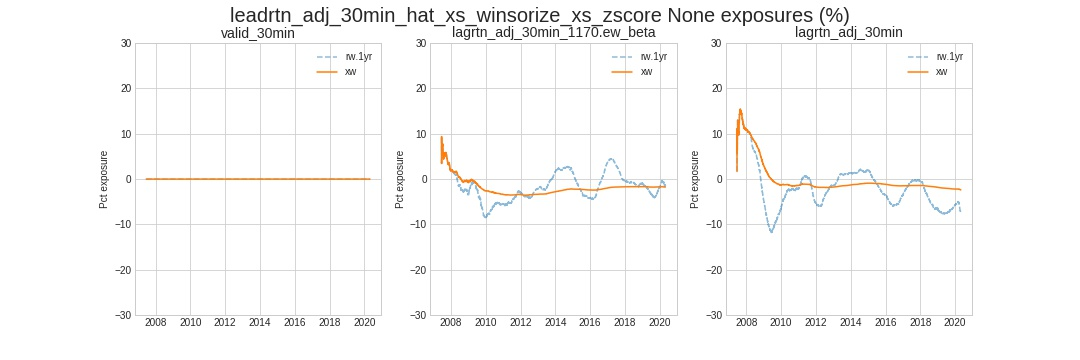

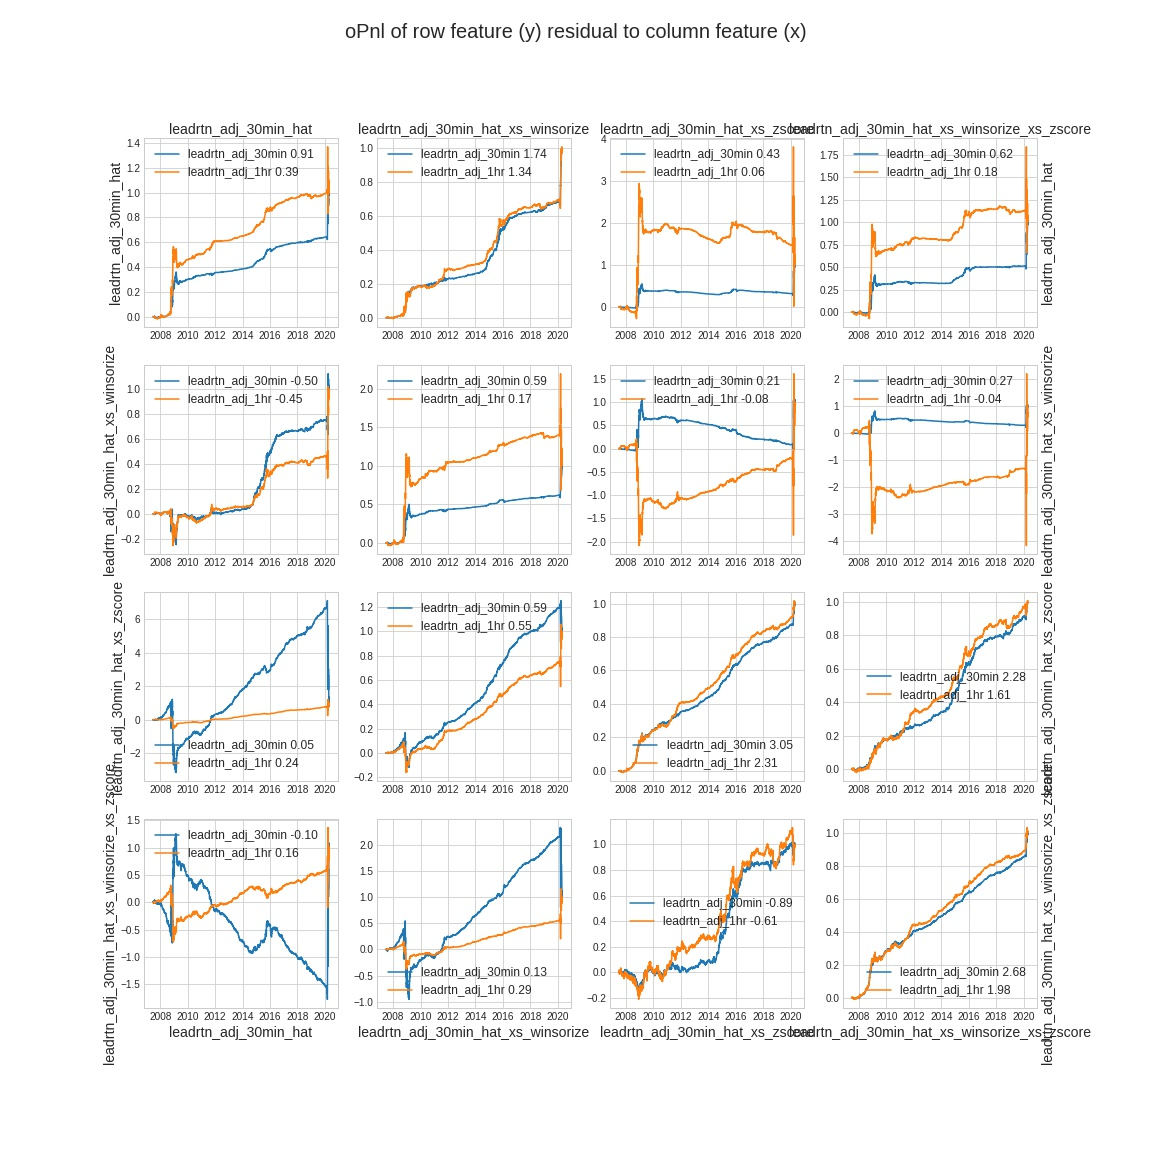

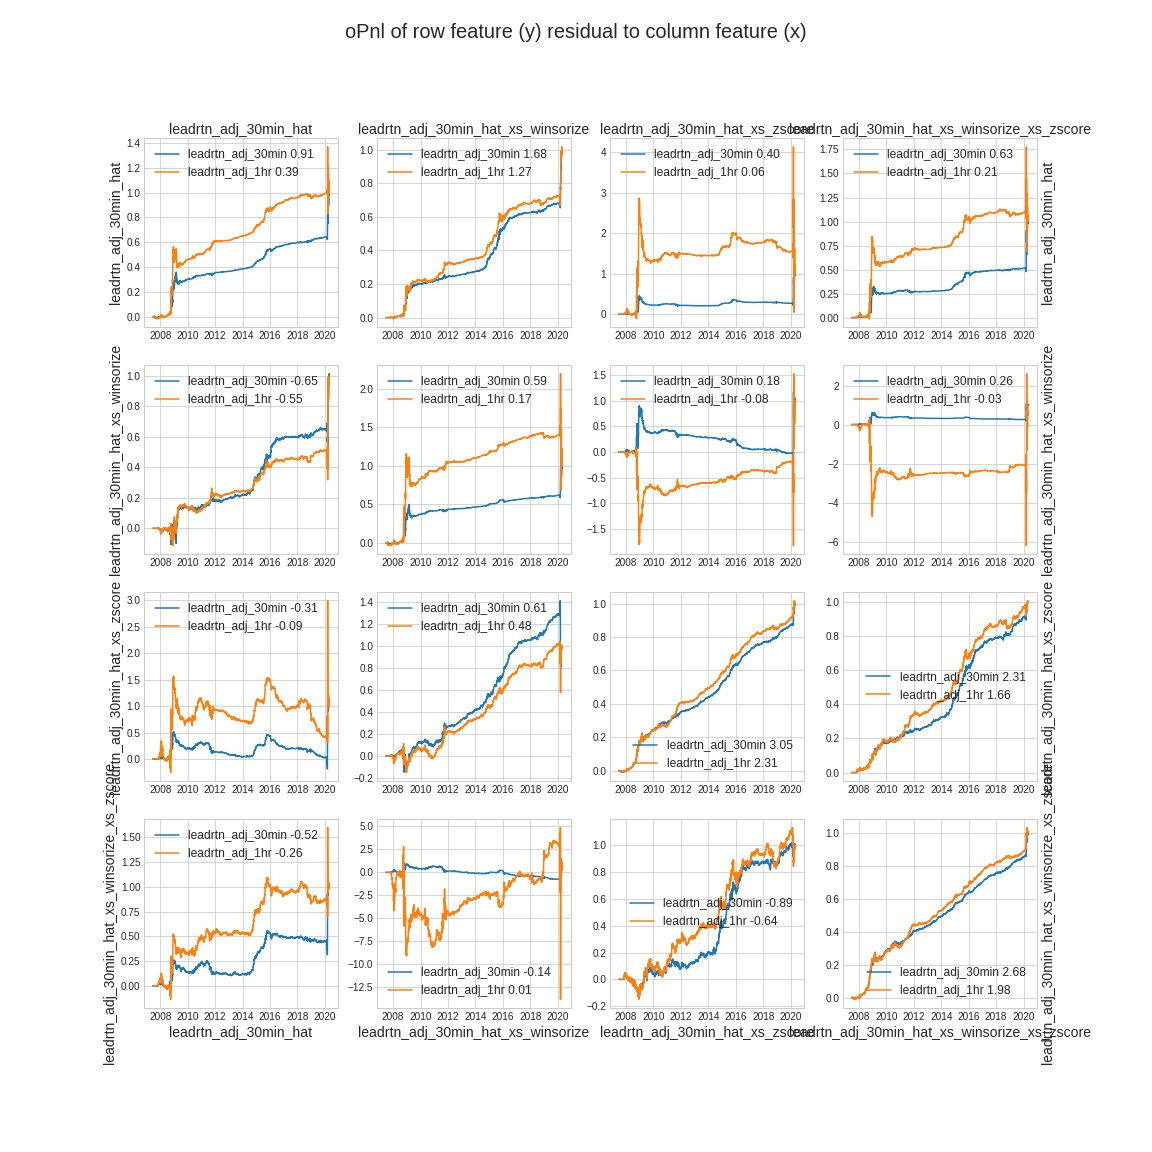

NameError: name 'baseline' is not defined

> <ipython-input-24-f7b5cea3d7c1>(145)<module>()
    143 
    144 #### compare against other baselines ####
--> 145 A = baseline
    146 comparator = mx.ForecastComparator( targets=hpso.regression_targets, weight=hpso.weight, winlen=100*13 )
    147 B = ref_baseline

ipdb> c


In [24]:
# OnlineRunner_854f955c7
##############
%inline

BASELINE_NAME = None
BASELINE_NOTES =  'Online pca (no kappa), factors as features and as residualizaiton target (on top of OnlineRunner_6c9fbc725)'
make_baseline = True

disp( BASELINE_NAME, h=1 )
disp( BASELINE_NOTES, h=3 )    

from research.etf_technical import online_runner as reor; reload( reor )

# use P omega weights as the baseline - which in turn also contains OnlineRunner_73844bf6b (primary baseline)
ref_baseline = mx.Baseline.load( 'OnlineRunner_6c9fbc725' )
data = mx.RenameFeatures( 
    new_features=[f'{ft}_OnlineRunner_6c9fbc725' for ft in ref_baseline.output_features] 
).set( data=ref_baseline, features=ref_baseline.output_features )

baseline_hps=mx.HPSet(
    online_hps = mx.HPSet(
        # stuff related to pre and post processing
        start=hps.start,
        end=hps.end,
        symbol=None,
        winsorize_target=False, #winsorize returns
        winsorize_features=0.01, # winsorize features
        demean_features=False,
        normalize_features=False,
        regression_exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min'],
        regression_targets=['leadrtn_adj_30min', 'leadrtn_adj_1hr'],
        # the feature sets
        features=sorted( set(
            []
            + ['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid', ]
            + hps.feature_set.lagging
            + hps.feature_set.vol
            + hps.feature_set.log_volumes
            # + hps.feature_set.calendar
            + hps.feature_set.mkt
            + hps.feature_set.betas
            # + hps.feature_set.technical
            # + hps.feature_set.afacs
        ) ),
        targets=['leadrtn_adj_30min'], #, 'leadrtn_adj_30min_disjoint.1', 'leadrtn_adj_30min_disjoint.2'],
        weight='valid_30min',
        # stuff related to online learning
        lookahead=2,
        ridge=1e-5,
        hl_1=None,
        hl_2=None,
        lr=500,
        kappa=2,  # util penalty
        tv=None,  # {1:1, 2:1, 13:1e-1},
        ortho=2,
        ortho_hl=13,
        # feautres to orthogonal out
        ortho_features=(
            []                
            + ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day']  # tilt and mean revrsion        
            + hps.feature_set.betas # market
             # reference baselines
            #+ ['leadrtn_adj_30min_hat_xs_winsorize_xs_zscore_OnlineRunner_6c9fbc725', leadrtn_adj_30min_hat_xs_winsorize_xs_zscore_OnlineRunner_73844bf6b]
        ),
        algo='mbprox',
        batch_size=5000,    
        # stuff related to sid weighting
        use_omega=False,
        omega_lr=10,
        omega_ridge=0,
        omega_shift=0.1,    
        # the transformer
        transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13 * 5, 13 * 20, 13 * 40], ),
    ),

    pca_hps = mx.HPSet(
        targets=['lagrtn_adj_30min', 'lagrtn_adj_1day'],
        weight=['weight'],
        halflife=30 * 13,
        rank=5,
        kappa=1e-1,
        ortho=1e-1,
        tv=None,
        ortho_halflife=None,    
        ortho_features=['valid_30min'] + hps.feature_set.betas, # take out tilt and market
        ridge=1e-6,
        batch_size=5000,
        factors_as_features=True, # use the pca factors as features
        factors_as_ortho=True, # use the factors as orthogonal features
        eigens_as_features=False, # the eigvenvalues as features
    )
)

disp( mx.tensorboard.start_server( 6007 ) )
disp( mx.tensorboard.start( clear=True ) )    
runner = reor.online_pipeline( data=data, online_hps=baseline_hps.online_hps, pca_hps=baseline_hps.pca_hps, memoize=True )
disp( f'Expected {BASELINE_NAME}  got ', runner.hash(), h=4, color='teal' )
disp( 'with features= ', runner.features , 'and ortho_features=', runner.hps.ortho_features,  )

# is this baselined  - then load from baseline cache
if BASELINE_NAME:
    # hash corruption somehwere - notify FJ
    if BASELINE_NAME != runner.hash():
        raise ValueError( f'baseline {name} does not match runner {runner.hash()} - make sure why this is the case ')
    baseline = mx.Baseline.load( BASELINE_NAME  )
    disp( 'loading ',  BASELINE_NAME, ' from baseline cache', h=3, color='orange' )        
    output_meta = baseline.output_meta
    output_features = baseline.output_features
# run the operator and 
else:
    runner.run()
    output_meta =  runner.output_meta
    output_features = runner.output_features
    # baseline this if needed
    if make_baseline:
        try:
            baseline = mx.Baseline.make( runner, hps=baseline_hps, notebook=mx.Config.code, notes=BASELINE_NOTES )
            disp( 'Baselined ', runner.hash(), h=4, color='teal' )
        except:
            disp( runner.hash(), 'already baselined - skipping', h=5, color='orange' )
    else:
        baseline = None

# --- show the results---
for profile in output_meta['profiler']:
    main_fig = profile['main_fig']
    exp_fig = profile['exp_fig']
    reg_fig = profile['reg_fig'] 
    reg_df = profile['regressions']
    if not reg_df.empty: reg_df = reg_df.set_index( ['returns', 'lag'] )
    disp( profile['feature'],  h=3, hr=True )    
    disp( 'Regressions', reg_df, h=4 )
    disp( reg_fig  )
    disp( exp_fig )
result = output_meta['comparator']
disp( f'Comparison for {output_features }', h=1 )
disp( 'Static Forecast correlations', result['fcst_corrs'], h=2 )
disp( 'Static Orthog SRs', result['static_osrs'], h=2 )
disp( 'Static Orthog Pnl', result['static_opnl'], h=2 )
if 'roll_osrs' in result:
    disp( 'Rolling Orthog SRs', result['roll_osrs'], h=2 )
    disp( 'Rolling Orthog Pnl', result['roll_opnl'], h=2 )


#### compare against other baselines ####
A = baseline    
comparator = mx.ForecastComparator( targets=baseline_hps.online_hps.regression_targets, weight=baseline_hps.online_hps.weight, winlen=100*13 )
B = ref_baseline
disp( 'Comparing A=', A.name, A.notes, '\n\t with B=', B.name , B.notes, h=3 )
comparator.compare( A,  B, A_features=A.output_features[-1],  B_features=['leadrtn_adj_30min_hat_xs_winsorize_xs_zscore_OnlineRunner_73844bf6b', B.output_features[-1]]  )   